In [69]:
# Notwendige Bibliotheken importieren
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import csv
import random
import streamlit as st
import matplotlib.pyplot as plt
import numpy as np
import tsfresh

# Funktion zum Einlesen der CSV-Dateien
df_Water = pd.read_csv('Water.csv')
df_Knocking = pd.read_csv('Knocking.csv')
df_Water.drop(['time'], axis=1, inplace=True)
df_Knocking.drop(['time'], axis=1, inplace=True)

# Label hinzufügen
df_Water['Label'] = 'Water'
df_Knocking['Label'] = 'Knocking'


# TODO: Checke ob hierdurch Informationsverlust
# Auf ganze Zahl runden
df_Water['dBFS'] = df_Water['dBFS'].round(decimals = 0)
df_Knocking['dBFS'] =  df_Knocking['dBFS'].round(decimals = 0)


# Daten in einzelne Samples aufteilen
split_Water = np.array_split(df_Water, len(df_Water)/20-1)
split_Knocking = np.array_split(df_Knocking, len(df_Knocking)/20-1)



# print(split_Water)

# Zusammenführen der beiden Dataframes (noch Water hinten und Knock vorne)

combined_df = []

features = pd.DataFrame()
#Feature-Enineering

for i in split_Knocking:
    combined_df.append(pd.DataFrame({"dBFS_Varianz": i["dBFS"].var(),"dBFS_STD" : i["dBFS"].std(), "dBFS_mean" : i["dBFS"].mean(),
    "dBFS_min" : i["dBFS"].min(), "dBFS_max" : i["dBFS"].max(), "dBFS_absMax" : i["dBFS"].abs().max(), "dBFS_sum" : i["dBFS"].sum(), "dBFS_median" : i["dBFS"].median(), "Label" : i["Label"]}))
        
for i in split_Water:
    combined_df.append(pd.DataFrame({"dBFS_Varianz": i["dBFS"].var(),"dBFS_STD" : i["dBFS"].std(), "dBFS_mean" : i["dBFS"].mean(),
    "dBFS_min" : i["dBFS"].min(), "dBFS_max" : i["dBFS"].max(), "dBFS_absMax" : i["dBFS"].abs().max(), "dBFS_sum" : i["dBFS"].sum(), "dBFS_median" : i["dBFS"].median(), "Label" : i["Label"]}))
      


In [70]:
combined_df[0].head(1)
final = []
for x in combined_df:

    final.append(x.head(1))

In [71]:
df_final = pd.concat(final)
df_final

,dBFS_STD,dBFS_mean,dBFS_max,dBFS_absMax,dBFS_sum,dBFS_median,Label
0,48.371775,-94.142857,0.0,160.0,-1977.0,-103.0,Knocking
21,45.310674,-81.571429,0.0,123.0,-1713.0,-104.0,Knocking
42,41.622682,-71.952381,0.0,112.0,-1511.0,-94.0,Knocking
63,43.919624,-71.666667,0.0,121.0,-1505.0,-89.0,Knocking
84,41.621080,-77.714286,0.0,117.0,-1632.0,-98.0,Knocking
...,...,...,...,...,...,...,...
5804,2.419221,-31.200000,-24.0,34.0,-624.0,-31.0,Water
5824,3.166851,-30.650000,-23.0,34.0,-613.0,-32.0,Water
5844,2.198085,-30.900000,-26.0,34.0,-618.0,-31.0,Water
5864,2.134306,-30.150000,-27.0,34.0,-603.0,-30.0,Water


In [73]:
# Aufteilen der Daten in Trainings- und Testdaten
x = df_final.drop(columns = ["Label"])
y = df_final["Label"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Erstelle den KNN-Klassifikator
knn = RandomForestClassifier()

# Trainiere den Klassifikator
knn.fit(X_train, y_train)

# Vorhersagen für die Testdaten machen
y_pred = knn.predict(X_test)

# Bewertung der Genauigkeit des Klassifikators
accuracy = accuracy_score(y_test, y_pred)
x_ = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print('Genauigkeit:', accuracy)
print('Präzision:', precision)
print('Recall:', recall)
print('Neu:', x_)


# Berechne die Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred)

# Gib die Konfusionsmatrix aus
print('Konfusionsmatrix:')
print(cm)

print(y_pred)

Genauigkeit: 1.0
Präzision: 1.0
Recall: 1.0
Neu:               precision    recall  f1-score   support

    Knocking       1.00      1.00      1.00        59
       Water       1.00      1.00      1.00        51

    accuracy                           1.00       110
   macro avg       1.00      1.00      1.00       110
weighted avg       1.00      1.00      1.00       110

Konfusionsmatrix:
[[59  0]
 [ 0 51]]
['Knocking' 'Knocking' 'Water' 'Knocking' 'Water' 'Water' 'Knocking'
 'Water' 'Knocking' 'Water' 'Knocking' 'Knocking' 'Knocking' 'Knocking'
 'Water' 'Knocking' 'Water' 'Knocking' 'Knocking' 'Water' 'Water'
 'Knocking' 'Water' 'Knocking' 'Knocking' 'Water' 'Knocking' 'Water'
 'Water' 'Water' 'Knocking' 'Water' 'Water' 'Knocking' 'Knocking'
 'Knocking' 'Knocking' 'Knocking' 'Water' 'Water' 'Knocking' 'Knocking'
 'Water' 'Knocking' 'Knocking' 'Water' 'Water' 'Water' 'Water' 'Water'
 'Water' 'Knocking' 'Knocking' 'Water' 'Water' 'Knocking' 'Water' 'Water'
 'Knocking' 'Water' 'Water' 

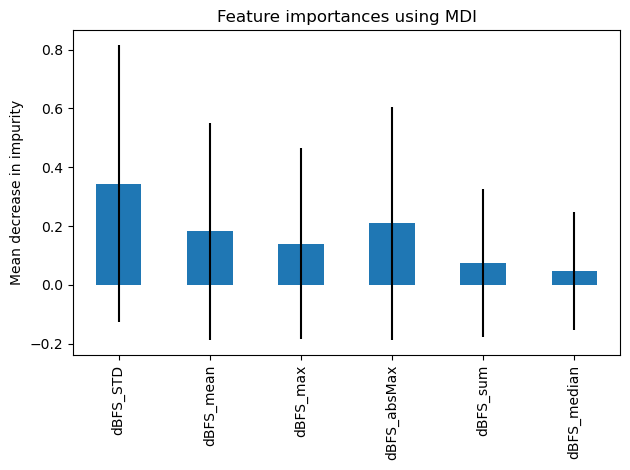

In [74]:
importance = knn.feature_importances_
std = np.std([tree.feature_importances_ for tree in knn.estimators_], axis=0)

forest_importances = pd.Series(importance, x.keys())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()